In [31]:
import numpy as np
import pandas as pd
from faker import Faker
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import faiss
import shap
from flask import Flask, render_template, request, jsonify
from datetime import datetime
import json
import warnings
from datetime import datetime
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import time
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# 1. Data Generation
class DataGenerator:
    def __init__(self):
        self.fake = Faker()
        self.universities = ['MIT', 'Stanford', 'Harvard', 'Berkeley', 'Oxford', 
                           'Cambridge', 'ETH Zurich', 'Imperial College']
        self.certifications = ['AWS', 'GCP', 'Azure', 'PMP', 'CISSP', 'CISA', 
                             'Six Sigma', 'Scrum Master']
        self.courses = ['Machine Learning', 'Data Science', 'Cloud Computing', 
                       'Project Management', 'Business Analytics']
        self.locations = ['New York', 'San Francisco', 'London', 'Berlin', 
                         'Singapore', 'Tokyo', 'Sydney']
        
    def generate_sample(self):
        return {
            'id': self.fake.uuid4(),
            'name': self.fake.name(),
            'months_experience': np.random.randint(0, 240),
            'education_years': np.random.randint(12, 22),
            'university_institution': np.random.choice(self.universities),
            'certifications': np.random.choice(self.certifications, 
                                             size=np.random.randint(0, 4)).tolist(),
            'awards': np.random.randint(0, 5),
            'courses': np.random.choice(self.courses, 
                                      size=np.random.randint(0, 4)).tolist(),
            'location': np.random.choice(self.locations),
            'recommendation': np.random.choice([0, 1], p=[0.7, 0.3])
        }
    
    def generate_dataset(self, n_samples=10000):
        return pd.DataFrame([self.generate_sample() for _ in range(n_samples)])

In [22]:

class PQModel:
    def __init__(self, n_bits=8):
        self.n_bits = n_bits
        self.label_encoders = {}
        self.scaler = StandardScaler()
        
    def _preprocess_features(self, df):
        df_processed = df.copy()
        
        # Handle categorical features
        categorical_cols = ['university_institution', 'location']
        for col in categorical_cols:
            if col not in self.label_encoders:
                self.label_encoders[col] = LabelEncoder().fit(df[col].unique())
            df_processed[col] = self.label_encoders[col].transform(df[col])
        
        # Handle list features
        list_cols = ['certifications', 'courses']
        for col in list_cols:
            df_processed[f'{col}_count'] = df[col].apply(len)
        
        # Select numerical features for PQ
        numerical_features = ['months_experience', 'education_years', 'awards', 
                            'certifications_count', 'courses_count',
                            'university_institution', 'location']
        
        if not hasattr(self, 'feature_names'):
            self.feature_names = numerical_features
            
        return self.scaler.fit_transform(df_processed[numerical_features]) if not hasattr(self, 'is_fitted') else self.scaler.transform(df_processed[numerical_features])
    
    def fit(self, df):
        X = self._preprocess_features(df)
        d = X.shape[1]
        
        # Determine number of subquantizers that divides the dimension evenly
        for i in range(1, d+1):
            if d % i == 0:
                self.n_subquantizers = i
                break
                
        print(f"Using {self.n_subquantizers} subquantizers for dimension {d}")
        
        self.is_fitted = True
        self.index = faiss.IndexPQ(d, self.n_subquantizers, self.n_bits, faiss.METRIC_L2)
        self.index.train(X.astype(np.float32))
        self.index.add(X.astype(np.float32))
        
        return self
    
    def predict(self, X):
        # This wrapper is specifically for SHAP
        if isinstance(X, np.ndarray):
            distances, _ = self.index.search(X.astype(np.float32), k=1)
            return -distances  # Convert distances to similarity scores
        else:
            X_processed = self._preprocess_features(X)
            distances, _ = self.index.search(X_processed.astype(np.float32), k=1)
            return -distances

In [27]:

class ModelExplainer:
    def __init__(self, pq_model):
        self.pq_model = pq_model
        
    def explain_model(self, df):
        try:
            # Preprocess the data
            X = self.pq_model._preprocess_features(df)
            
            # Create background data
            background_data = X[:100]  # Use first 100 samples as background
            
            # Create explainer with simplified predict function
            explainer = shap.KernelExplainer(
                lambda x: self.pq_model.predict(x),
                background_data,
                n_samples=50
            )
            
            # Calculate SHAP values for a subset
            sample_size = min(100, X.shape[0])
            shap_values = explainer.shap_values(X[:sample_size])
            
            if isinstance(shap_values, list):
                shap_values = shap_values[0]
            
            # Calculate feature importance and convert to proper types
            feature_importance = {
                str(feature): float(importance)
                for feature, importance in zip(
                    self.pq_model.feature_names,
                    np.abs(shap_values).mean(0)
                )
            }
            
            return {
                'feature_importance': feature_importance,
                'shap_values': shap_values.tolist() if isinstance(shap_values, np.ndarray) else shap_values
            }
        except Exception as e:
            print(f"Error in explain_model: {str(e)}")
            return None

In [5]:
# 4. Feedback Tracking
class FeedbackTracker:
    def __init__(self):
        self.feedback_data = []
        
    def add_feedback(self, candidate_id, stage, status, notes=None):
        feedback = {
            'candidate_id': candidate_id,
            'stage': stage,
            'status': status,
            'timestamp': datetime.now().isoformat(),
            'notes': notes
        }
        self.feedback_data.append(feedback)
        return feedback
    
    def get_candidate_history(self, candidate_id):
        return [f for f in self.feedback_data if f['candidate_id'] == candidate_id]
    
    def get_conversion_rates(self):
        stages = ['initial_screening', 'interview', 'offer', 'hired']
        conversion_rates = {}
        
        for i in range(len(stages)-1):
            current_stage = stages[i]
            next_stage = stages[i+1]
            
            current_count = len([f for f in self.feedback_data if f['stage'] == current_stage])
            next_count = len([f for f in self.feedback_data if f['stage'] == next_stage])
            
            if current_count > 0:
                conversion_rates[f'{current_stage}_to_{next_stage}'] = next_count / current_count
                
        return conversion_rates


In [6]:
# 5. Model Drift Detection
class DriftDetector:
    def __init__(self, initial_data, threshold=0.1):
        self.baseline_distribution = self._calculate_distribution(initial_data)
        self.threshold = threshold
        
    def _calculate_distribution(self, data):
        numerical_cols = ['months_experience', 'education_years', 'awards']
        return {col: {'mean': data[col].mean(), 'std': data[col].std()} 
                for col in numerical_cols}
    
    def check_drift(self, new_data):
        current_distribution = self._calculate_distribution(new_data)
        drift_metrics = {}
        
        for feature in self.baseline_distribution.keys():
            baseline = self.baseline_distribution[feature]
            current = current_distribution[feature]
            
            mean_diff = abs(baseline['mean'] - current['mean']) / baseline['mean']
            std_diff = abs(baseline['std'] - current['std']) / baseline['std']
            
            drift_metrics[feature] = {
                'mean_drift': mean_diff,
                'std_drift': std_diff,
                'requires_attention': mean_diff > self.threshold or std_diff > self.threshold
            }
            
        return drift_metrics

In [32]:
class RecruitmentVisualizer:
    def __init__(self, pq_model, feedback_tracker):
        self.pq_model = pq_model
        self.feedback_tracker = feedback_tracker
        self.geolocator = Nominatim(user_agent="recruitment_visualizer")
        
        # Define status colors
        self.status_colors = {
            'current_employee': '#2ecc71',  # Green
            'offer_extended': '#f1c40f',    # Yellow
            'interview': '#e67e22',         # Orange
            'screening': '#3498db',         # Blue
            'rejected': '#e74c3c'           # Red
        }
        
    def _get_coordinates(self, location):
        """Get coordinates for a location with retry logic"""
        max_retries = 3
        for i in range(max_retries):
            try:
                time.sleep(1)  # Respect API limits
                loc = self.geolocator.geocode(location)
                if loc:
                    return loc.latitude, loc.longitude
                return None
            except GeocoderTimedOut:
                if i == max_retries - 1:
                    return None
                continue
            
    def create_talent_pool_visualization(self, current_employees_df, leads_df):
        """
        Create a TSNE visualization of current employees and leads
        """
        # Combine current employees and leads
        current_employees_df['status'] = 'current_employee'
        combined_df = pd.concat([current_employees_df, leads_df])
        
        # Preprocess features
        X = self.pq_model._preprocess_features(combined_df)
        
        # Apply t-SNE
        tsne = TSNE(n_components=2, random_state=42)
        X_tsne = tsne.fit_transform(X)
        
        # Create visualization
        plt.figure(figsize=(12, 8))
        
        # Plot current employees
        mask_current = combined_df['status'] == 'current_employee'
        plt.scatter(X_tsne[mask_current, 0], X_tsne[mask_current, 1], 
                   c=self.status_colors['current_employee'], 
                   label='Current Employees', alpha=0.6, s=100)
        
        # Plot leads by status
        for status in ['offer_extended', 'interview', 'screening', 'rejected']:
            mask = combined_df['status'] == status
            if mask.any():
                plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
                          c=self.status_colors[status],
                          label=status.replace('_', ' ').title(),
                          alpha=0.6, s=100)
        
        plt.title('Talent Pool Visualization')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        
        return plt.gcf()
    
    def create_geographical_heatmap(self, employees_df):
        """
        Create a geographical heatmap of high-quality employees
        """
        # Calculate employee quality scores
        quality_scores = self.pq_model.predict(employees_df)
        employees_df['quality_score'] = -quality_scores  # Convert distance to score
        
        # Get coordinates for each location
        location_data = []
        unique_locations = employees_df['location'].unique()
        
        for location in unique_locations:
            coords = self._get_coordinates(location)
            if coords:
                # Calculate weighted score for this location
                location_score = employees_df[
                    employees_df['location'] == location
                ]['quality_score'].mean()
                
                location_data.append({
                    'location': location,
                    'lat': coords[0],
                    'lon': coords[1],
                    'score': float(location_score),
                    'count': int(employees_df[
                        employees_df['location'] == location
                    ].shape[0])
                })
        
        # Create map centered on mean coordinates
        location_df = pd.DataFrame(location_data)
        center_lat = location_df['lat'].mean()
        center_lon = location_df['lon'].mean()
        
        m = folium.Map(location=[center_lat, center_lon], zoom_start=3)
        
        # Add heatmap layer
        heat_data = [[row['lat'], row['lon'], row['score'] * row['count']] 
                    for _, row in location_df.iterrows()]
        HeatMap(heat_data).add_to(m)
        
        # Add markers with information
        for _, row in location_df.iterrows():
            folium.CircleMarker(
                location=[row['lat'], row['lon']],
                radius=10,
                popup=f"""
                <b>{row['location']}</b><br>
                Employees: {row['count']}<br>
                Avg Quality: {row['score']:.2f}
                """,
                color='red',
                fill=True,
                fill_color='red'
            ).add_to(m)
        
        return m
    
    def create_recruitment_funnel(self):
        """
        Create a visualization of the recruitment funnel
        """
        stages = ['screening', 'interview', 'offer_extended', 'hired']
        stage_counts = {}
        
        for stage in stages:
            stage_counts[stage] = len([
                f for f in self.feedback_tracker.feedback_data 
                if f['stage'] == stage
            ])
        
        # Create funnel visualization
        plt.figure(figsize=(10, 6))
        y_pos = range(len(stages))
        counts = [stage_counts[stage] for stage in stages]
        
        plt.barh(y_pos, counts)
        plt.yticks(y_pos, [s.replace('_', ' ').title() for s in stages])
        plt.xlabel('Number of Candidates')
        plt.title('Recruitment Funnel')
        
        # Add conversion rates
        for i in range(len(stages)-1):
            if counts[i] > 0:
                conversion = (counts[i+1] / counts[i]) * 100
                plt.text(counts[i], i, f'{conversion:.1f}%', 
                        va='center', ha='left', color='red')
        
        plt.tight_layout()
        return plt.gcf()

In [36]:
# 1. Test Data Generation
print("Testing Data Generation...")
data_generator = DataGenerator()
df = data_generator.generate_dataset(n_samples=1000)

print("\nDataset Shape:", df.shape)
print("\nSample of generated data:")
print(df.head())


Testing Data Generation...

Dataset Shape: (1000, 10)

Sample of generated data:
                                     id               name  months_experience  \
0  2fd3ca2e-91e4-4228-9670-0cd59c641725        Alyssa Gray                237   
1  2823eabe-c520-45ca-b7d5-49640a6ff024       Leslie Owens                104   
2  cb57e124-fc5e-4b74-a4cd-ef6938afbf50        Mary Sutton                116   
3  58bbc4f6-35f8-4d39-af81-a0b267bd7da9       David Davila                  7   
4  171df191-243e-4096-b80a-d8c4f8b59e65  Elizabeth Lindsey                199   

   education_years university_institution           certifications  awards  \
0               16               Stanford   [Six Sigma, Six Sigma]       2   
1               17                    MIT                       []       0   
2               20                 Oxford  [Six Sigma, CISSP, AWS]       0   
3               21                 Oxford                    [PMP]       4   
4               17               Stanford 

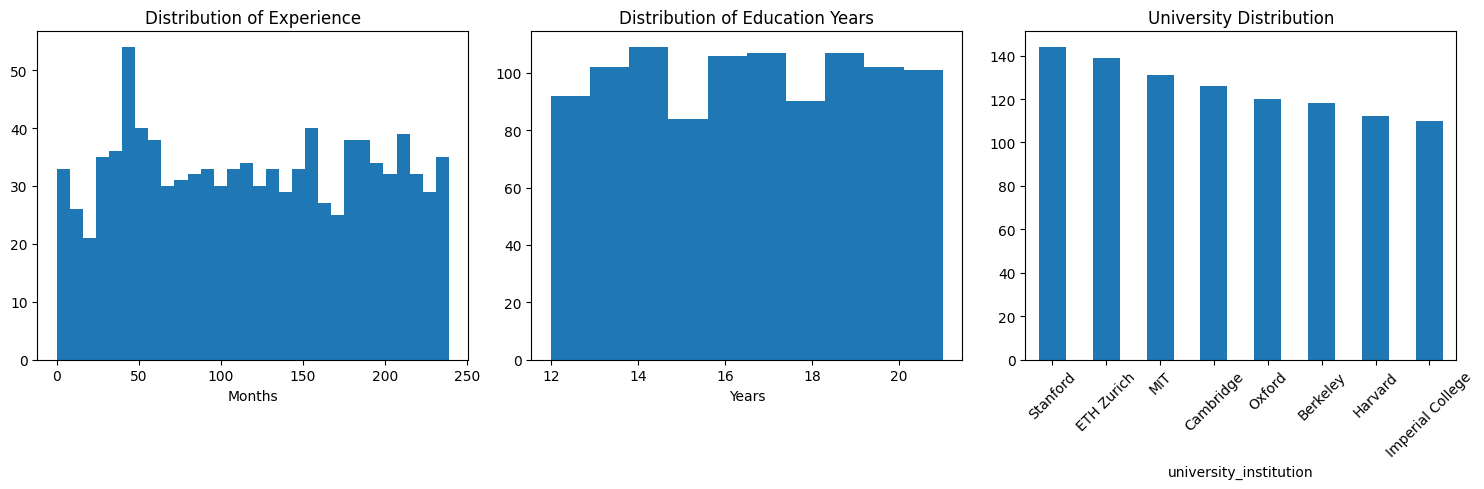

In [24]:
# Visualize some distributions
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.hist(df['months_experience'], bins=30)
plt.title('Distribution of Experience')
plt.xlabel('Months')

plt.subplot(132)
plt.hist(df['education_years'], bins=10)
plt.title('Distribution of Education Years')
plt.xlabel('Years')

plt.subplot(133)
df['university_institution'].value_counts().plot(kind='bar')
plt.title('University Distribution')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [25]:
# 2. Test PQ Model
print("\nTesting Product Quantization Model...")
pq_model = PQModel(n_bits=8)
pq_model.fit(df)

# Test prediction with a sample candidate
sample_candidate = data_generator.generate_sample()
sample_df = pd.DataFrame([sample_candidate])
prediction = pq_model.predict(sample_df)
print("\nSample Candidate Similarity Score:", float(-prediction[0]))



Testing Product Quantization Model...
Using 1 subquantizers for dimension 7


WARNING clustering 1000 points to 256 centroids: please provide at least 9984 training points



Sample Candidate Similarity Score: 1.2775269746780396



Testing Model Explainability...


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:03<00:00, 30.03it/s]


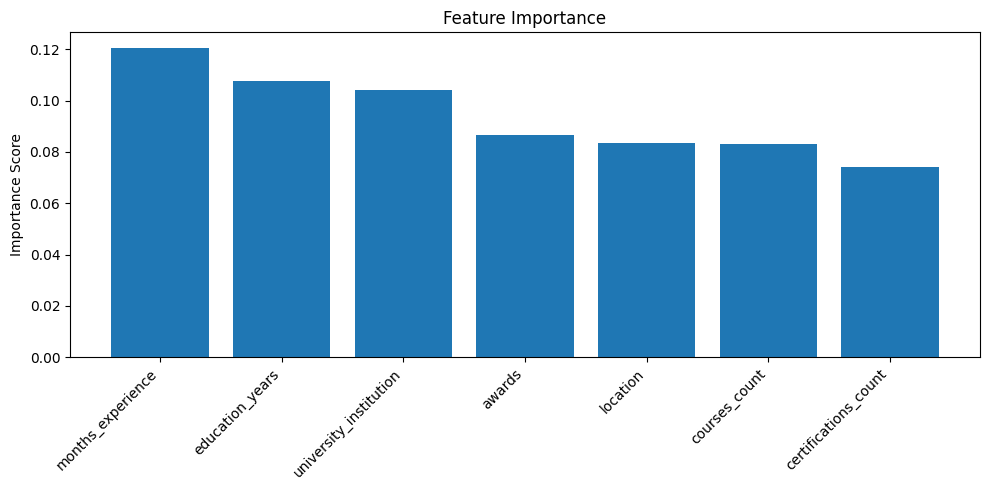


Feature Importance Rankings:
months_experience: 0.1205
education_years: 0.1076
university_institution: 0.1041
awards: 0.0867
location: 0.0835
courses_count: 0.0832
certifications_count: 0.0742

Testing Complete!


In [28]:
# 3. Test Model Explainability
print("\nTesting Model Explainability...")
explainer = ModelExplainer(pq_model)
explanation = explainer.explain_model(df)

if explanation:
    # Convert feature importance to proper format
    importance_dict = {
        str(k): float(v) for k, v in explanation['feature_importance'].items()
    }
    
    # Create DataFrame with proper types
    importance_df = pd.DataFrame([
        {'Feature': str(k), 'Importance': float(v)} 
        for k, v in importance_dict.items()
    ])
    
    # Sort by importance
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    # Create plot
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(importance_df)), 
           importance_df['Importance'],
           tick_label=importance_df['Feature'])
    plt.title('Feature Importance')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Importance Score')
    plt.tight_layout()
    plt.show()
    
    print("\nFeature Importance Rankings:")
    for _, row in importance_df.iterrows():
        print(f"{row['Feature']}: {row['Importance']:.4f}")
else:
    print("Error occurred during model explanation")

print("\nTesting Complete!")

In [29]:
# 4. Test Feedback Tracking
print("\nTesting Feedback Tracking...")
feedback_tracker = FeedbackTracker()

# Add some sample feedback
stages = ['initial_screening', 'interview', 'offer', 'hired']
statuses = ['pass', 'fail']

for i in range(50):  # Add 50 feedback entries
    candidate_id = df['id'].iloc[i]
    stage = np.random.choice(stages)
    status = np.random.choice(statuses)
    feedback_tracker.add_feedback(candidate_id, stage, status, 
                                notes=f"Test feedback for candidate {i}")

# Check conversion rates
conversion_rates = feedback_tracker.get_conversion_rates()
print("\nConversion Rates:")
for stage, rate in conversion_rates.items():
    print(f"{stage}: {rate:.2%}")



Testing Feedback Tracking...

Conversion Rates:
initial_screening_to_interview: 133.33%
interview_to_offer: 83.33%
offer_to_hired: 190.00%



Testing Drift Detection...

Drift Metrics:

months_experience:
Mean drift: 0.1824
Std drift: 0.2153
Requires attention: True

education_years:
Mean drift: 0.0080
Std drift: 0.0033
Requires attention: False

awards:
Mean drift: 0.0173
Std drift: 0.0263
Requires attention: False


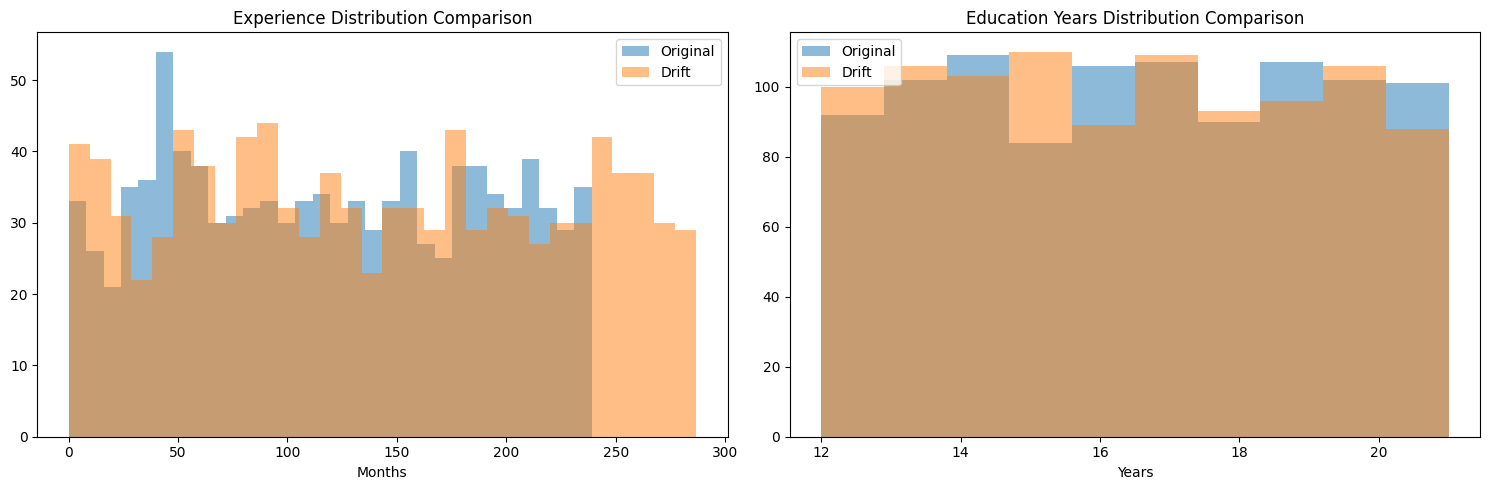

In [30]:
# 5. Test Drift Detection
print("\nTesting Drift Detection...")
drift_detector = DriftDetector(df)

# Generate some drift data by modifying distributions
drift_data = data_generator.generate_dataset(n_samples=1000)
drift_data['months_experience'] = drift_data['months_experience'] * 1.2  # Introduce drift

drift_metrics = drift_detector.check_drift(drift_data)
print("\nDrift Metrics:")
for feature, metrics in drift_metrics.items():
    print(f"\n{feature}:")
    print(f"Mean drift: {metrics['mean_drift']:.4f}")
    print(f"Std drift: {metrics['std_drift']:.4f}")
    print(f"Requires attention: {metrics['requires_attention']}")

# Visualize drift
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.hist(df['months_experience'], bins=30, alpha=0.5, label='Original')
plt.hist(drift_data['months_experience'], bins=30, alpha=0.5, label='Drift')
plt.title('Experience Distribution Comparison')
plt.xlabel('Months')
plt.legend()

plt.subplot(122)
plt.hist(df['education_years'], bins=10, alpha=0.5, label='Original')
plt.hist(drift_data['education_years'], bins=10, alpha=0.5, label='Drift')
plt.title('Education Years Distribution Comparison')
plt.xlabel('Years')
plt.legend()

plt.tight_layout()
plt.show()